In [ ]:
# ### mount on google drive if the user use colab.
# from google.colab import drive
# drive.mount('/content/drive/')
# import os
# os.chdir("/content/drive/My Drive/WatNet/notebooks")


In [1]:
import os
os.chdir('..')
import glob
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from notebooks import config
import matplotlib.pyplot as plt
from dataloader.img_aug import img_aug
from utils.imgShow import imgShow, imsShow
from model.seg_model.watnet import watnet
from model.seg_model.deeplabv3_plus import deeplabv3_plus
from model.seg_model.deepwatermapv2 import deepwatermapv2
from dataloader.tfrecord_io import parse_image,parse_shape,toPatchPair


## Data loading
### _Load and parse the tfrecord data_

In [2]:
### data loading from .tfrecord file
path_tra_data_scene = 'data/tfrecord-s2/tra_data_scene.tfrecords'
path_val_data_scene = 'data/tfrecord-s2/val_data_scene.tfrecords'
path_val_data_patch = 'data/tfrecord-s2/val_data_patch.tfrecords'
## training data
# tra_dset = tf.data.TFRecordDataset(path_tra_data_scene)  # train/val training
tra_dset = tf.data.TFRecordDataset([path_tra_data_scene, path_val_data_scene]) # final training

tra_dset = tra_dset.map(parse_image).map(parse_shape)\
            .cache()\
            .map(toPatchPair)\
            .map(img_aug)
tra_dset = tra_dset.shuffle(config.buffer_size).batch(config.batch_size)

## validation data
val_dset = tf.data.TFRecordDataset(path_val_data_patch)
val_dset = val_dset.map(parse_image).map(parse_shape)\
            .map(toPatchPair)\
            .cache()

val_dset = val_dset.batch(16)


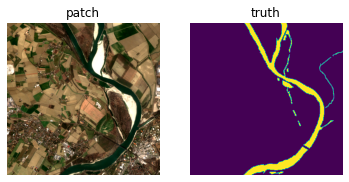

num: 24
time: 5.126646280288696


In [3]:
# for i in range(5):
start = time.time()
i = 0
for patch, truth in tra_dset:
    i+=1
imsShow(img_list=[patch[0], truth[0]], 
        img_name_list=['patch', 'truth'],
        clip_list=[2,0])

plt.show()
print('num of batch:', i)
print('time:', time.time()-start)


In [4]:
## model configuration
model = watnet(input_shape=(config.patch_size, config.patch_size, config.num_bands), nclasses=2)
# model = deeplabv3_plus(nclasses=2, input_shape=(config.patch_size, config.patch_size, config.num_bands))
# model = deepwatermapv2(min_width=4)



*** Building watnet network ***
*** Output_Shape => (None, 512, 512, 1) ***


In [6]:
'''------1. train step------'''
@tf.function
def train_step(model, loss_fun, optimizer, x, y):
    with tf.GradientTape() as tape:
        y_pre = model(x, training=True)
        loss = loss_fun(y, y_pre)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    config.tra_loss.update_state(loss)
    config.tra_oa.update_state(y, y_pre)
    config.tra_miou.update_state(y, y_pre)
    return config.tra_loss.result(), config.tra_oa.result(), config.tra_miou.result()

'''------2. test step------'''
@tf.function
def test_step(model, loss_fun, x, y):
    with tf.GradientTape() as tape:
        y_pre = model(x, training=False)
        loss = loss_fun(y, y_pre)
    config.val_loss.update_state(loss) 
    config.val_oa.update_state(y, y_pre)
    config.val_miou.update_state(y, y_pre)
    return config.val_loss.result(), config.val_oa.result(), config.val_miou.result()

'''------3. train loops------'''
def train_loops(model, loss_fun, optimizer, tra_dset, val_dset, epochs):
    miou_plot, loss_plot = [], []
    for epoch in range(epochs):
        start = time.time()
        ###--- train the model ---
        for x_batch, y_batch in tra_dset:
            tra_loss_epoch, tra_oa_epoch,tra_miou_epoch = train_step(model, loss_fun, optimizer, x_batch, y_batch)
        ### --- test the model ---
        # if epoch == 0 or epoch>200:
        for x_batch, y_batch in val_dset:
            val_loss_epoch, val_oa_epoch, val_miou_epoch = test_step(model, loss_fun, x_batch, y_batch)
        ### --- update the metrics ---
        config.tra_loss.reset_states(), config.tra_oa.reset_states(), config.tra_miou.reset_states()
        config.val_loss.reset_states(), config.val_oa.reset_states(), config.val_miou.reset_states()
        format = 'Ep {}: traLoss:{:.3f},traOA:{:.3f},traMIoU:{:.3f},valLoss:{:.3f},valOA:{:.3f},valMIoU:{:.3f},time:{:.1f}s'
        print(format.format(epoch + 1, tra_loss_epoch, tra_oa_epoch, tra_miou_epoch, val_loss_epoch, val_oa_epoch, val_miou_epoch, time.time() - start))
        miou_plot.append(val_miou_epoch.numpy())
        loss_plot.append(val_loss_epoch.numpy())
        ## --- visualize the results ---
        if epoch%10 == 0:
            i = np.random.randint(16)
            for val_patch, val_truth in val_dset.take(1):
                plt.figure(figsize=(10,4))
                pre = model(val_patch, training=False)
                imsShow(img_list=[val_patch.numpy()[i], val_truth.numpy()[i], pre.numpy()[i]], \
                        img_name_list=['val_patch', 'val_truth', 'prediction'], \
                        clip_list=[2,0,0],\
                        color_bands_list=None)
                plt.show()
    
    return miou_plot, loss_plot


Ep 1: traLoss:0.302,traOA:0.876,traMIoU:0.727,valLoss:0.546,valOA:0.771,valMIoU:0.385,time:22.8s


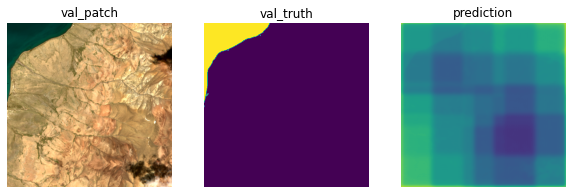

Ep 2: traLoss:0.169,traOA:0.935,traMIoU:0.841,valLoss:0.542,valOA:0.771,valMIoU:0.385,time:10.1s
Ep 3: traLoss:0.149,traOA:0.942,traMIoU:0.859,valLoss:0.524,valOA:0.771,valMIoU:0.385,time:9.8s
Ep 4: traLoss:0.150,traOA:0.946,traMIoU:0.867,valLoss:0.482,valOA:0.771,valMIoU:0.385,time:9.9s
Ep 5: traLoss:0.129,traOA:0.953,traMIoU:0.888,valLoss:0.444,valOA:0.771,valMIoU:0.385,time:9.6s
Ep 6: traLoss:0.130,traOA:0.954,traMIoU:0.878,valLoss:0.463,valOA:0.771,valMIoU:0.385,time:9.8s
Ep 7: traLoss:0.089,traOA:0.967,traMIoU:0.908,valLoss:0.479,valOA:0.771,valMIoU:0.385,time:10.1s
Ep 8: traLoss:0.083,traOA:0.971,traMIoU:0.925,valLoss:0.539,valOA:0.771,valMIoU:0.385,time:9.8s
Ep 9: traLoss:0.107,traOA:0.956,traMIoU:0.888,valLoss:0.591,valOA:0.771,valMIoU:0.385,time:9.8s
Ep 10: traLoss:0.095,traOA:0.965,traMIoU:0.907,valLoss:0.618,valOA:0.771,valMIoU:0.385,time:10.0s
Ep 11: traLoss:0.070,traOA:0.977,traMIoU:0.940,valLoss:0.558,valOA:0.771,valMIoU:0.385,time:10.0s


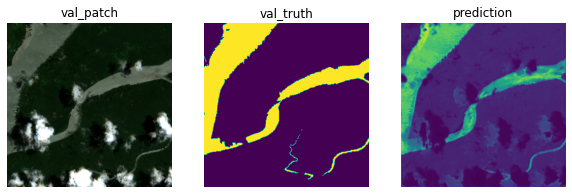

Ep 12: traLoss:0.088,traOA:0.969,traMIoU:0.919,valLoss:0.471,valOA:0.772,valMIoU:0.389,time:9.5s
Ep 13: traLoss:0.067,traOA:0.977,traMIoU:0.937,valLoss:0.409,valOA:0.773,valMIoU:0.394,time:9.9s
Ep 14: traLoss:0.089,traOA:0.973,traMIoU:0.927,valLoss:0.337,valOA:0.772,valMIoU:0.391,time:9.5s
Ep 15: traLoss:0.095,traOA:0.969,traMIoU:0.919,valLoss:0.264,valOA:0.789,valMIoU:0.434,time:9.9s
Ep 16: traLoss:0.090,traOA:0.970,traMIoU:0.922,valLoss:0.208,valOA:0.857,valMIoU:0.611,time:9.8s
Ep 17: traLoss:0.088,traOA:0.967,traMIoU:0.917,valLoss:0.262,valOA:0.802,valMIoU:0.468,time:9.7s
Ep 18: traLoss:0.099,traOA:0.961,traMIoU:0.893,valLoss:0.238,valOA:0.853,valMIoU:0.601,time:9.7s
Ep 19: traLoss:0.089,traOA:0.970,traMIoU:0.920,valLoss:0.363,valOA:0.815,valMIoU:0.501,time:9.8s
Ep 20: traLoss:0.108,traOA:0.961,traMIoU:0.902,valLoss:0.060,valOA:0.982,valMIoU:0.951,time:9.5s
Ep 21: traLoss:0.084,traOA:0.971,traMIoU:0.925,valLoss:0.065,valOA:0.983,valMIoU:0.953,time:9.6s


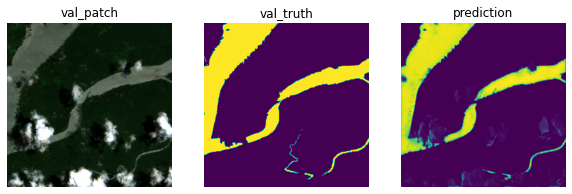

Ep 22: traLoss:0.084,traOA:0.970,traMIoU:0.923,valLoss:0.193,valOA:0.891,valMIoU:0.710,time:9.8s
Ep 23: traLoss:0.081,traOA:0.971,traMIoU:0.923,valLoss:0.054,valOA:0.985,valMIoU:0.958,time:9.9s
Ep 24: traLoss:0.065,traOA:0.976,traMIoU:0.937,valLoss:0.063,valOA:0.983,valMIoU:0.952,time:9.8s
Ep 25: traLoss:0.079,traOA:0.972,traMIoU:0.928,valLoss:0.208,valOA:0.900,valMIoU:0.733,time:9.9s
Ep 26: traLoss:0.089,traOA:0.971,traMIoU:0.928,valLoss:0.678,valOA:0.855,valMIoU:0.620,time:9.9s
Ep 27: traLoss:0.076,traOA:0.975,traMIoU:0.937,valLoss:0.058,valOA:0.981,valMIoU:0.948,time:9.9s
Ep 28: traLoss:0.070,traOA:0.976,traMIoU:0.933,valLoss:0.668,valOA:0.828,valMIoU:0.537,time:9.8s
Ep 29: traLoss:0.074,traOA:0.975,traMIoU:0.930,valLoss:0.208,valOA:0.858,valMIoU:0.616,time:9.8s
Ep 30: traLoss:0.082,traOA:0.972,traMIoU:0.930,valLoss:0.090,valOA:0.976,valMIoU:0.932,time:9.9s
Ep 31: traLoss:0.076,traOA:0.972,traMIoU:0.930,valLoss:0.099,valOA:0.960,valMIoU:0.900,time:9.6s


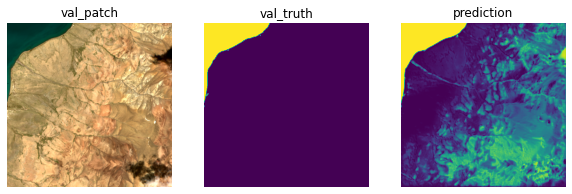

Ep 32: traLoss:0.077,traOA:0.974,traMIoU:0.933,valLoss:0.073,valOA:0.974,valMIoU:0.931,time:9.9s
Ep 33: traLoss:0.058,traOA:0.978,traMIoU:0.942,valLoss:0.101,valOA:0.959,valMIoU:0.888,time:9.7s
Ep 34: traLoss:0.092,traOA:0.964,traMIoU:0.910,valLoss:0.063,valOA:0.977,valMIoU:0.937,time:9.7s
Ep 35: traLoss:0.082,traOA:0.970,traMIoU:0.925,valLoss:0.048,valOA:0.984,valMIoU:0.956,time:9.9s
Ep 36: traLoss:0.081,traOA:0.970,traMIoU:0.920,valLoss:0.131,valOA:0.922,valMIoU:0.788,time:9.9s
Ep 37: traLoss:0.096,traOA:0.969,traMIoU:0.919,valLoss:0.069,valOA:0.973,valMIoU:0.929,time:9.7s
Ep 38: traLoss:0.092,traOA:0.966,traMIoU:0.906,valLoss:0.076,valOA:0.974,valMIoU:0.931,time:10.0s
Ep 39: traLoss:0.090,traOA:0.969,traMIoU:0.923,valLoss:0.069,valOA:0.977,valMIoU:0.936,time:9.6s
Ep 40: traLoss:0.093,traOA:0.972,traMIoU:0.927,valLoss:0.112,valOA:0.963,valMIoU:0.904,time:9.8s
Ep 41: traLoss:0.089,traOA:0.967,traMIoU:0.916,valLoss:0.098,valOA:0.976,valMIoU:0.934,time:9.7s


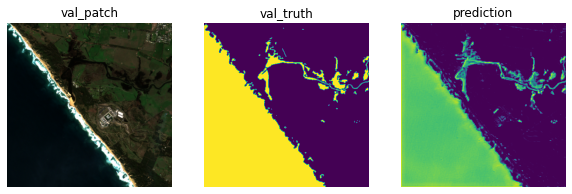

Ep 42: traLoss:0.077,traOA:0.974,traMIoU:0.933,valLoss:0.213,valOA:0.880,valMIoU:0.675,time:9.7s
Ep 43: traLoss:0.077,traOA:0.971,traMIoU:0.922,valLoss:0.051,valOA:0.987,valMIoU:0.965,time:9.8s
Ep 44: traLoss:0.095,traOA:0.963,traMIoU:0.908,valLoss:0.080,valOA:0.978,valMIoU:0.940,time:9.8s


In [7]:
## training
with tf.device('/device:GPU:1'):
    miou_plot, loss_plot =train_loops(model=model, \
                        loss_fun=config.loss_bce, \
                        optimizer=config.opt_adam, \
                        tra_dset=tra_dset, \
                        val_dset=val_dset, \
                        epochs=config.epochs,
                        )


In [ ]:
# ## saving metric
# metric_path = "result/metrics_watnet.csv"
# dataframe = pd.DataFrame({'val_miou':miou_plot, 'val_loss':loss_plot})
# dataframe.to_csv(metric_path, index=False, sep=',')



In [ ]:
# # model saving.h5
# path_save = 'model/pretrained/watnetv2.h5'
# path_save = 'model/pretrained/deepwatermapv2.h5'
# model.save(path_save)
